# Предсказание дождя

### Анализ:
1. Посмотреть, 365 дней - это весь год?
### Фичи:
1. Учитывать предыдущие значения
2. Сезонные фичи если это дни года
3. Категориальные - направление ветра, но также ее можно и как числовую
4. Проверить корреляцию, возможно не от количественных, а вообще от факта ветра, солнца и т.д.
### Обучение:
1. Как обычную классификацию обучать
2. Попробовать как временной ряд, учитывать предыдущие значения
### Модели:
1. Регрессия
2. Бустинги
3. Случаный лес
4. Автомл
5. Нейронки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from scipy import interpolate

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [4]:
train.head(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [5]:
train.shape

(2190, 13)

In [6]:
test.head(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


## Анализ

In [7]:
def plot_days(df):
    """График распределения поля day"""

    plt.figure(figsize=(16,4))
    ax = sns.countplot(x='day', data=df, width=0.8)

    # Оставляем только нужные метки (каждый 5-й день)
    ax.set_xticks(range(0, len(df['day'].unique()), 10))  

    plt.show()

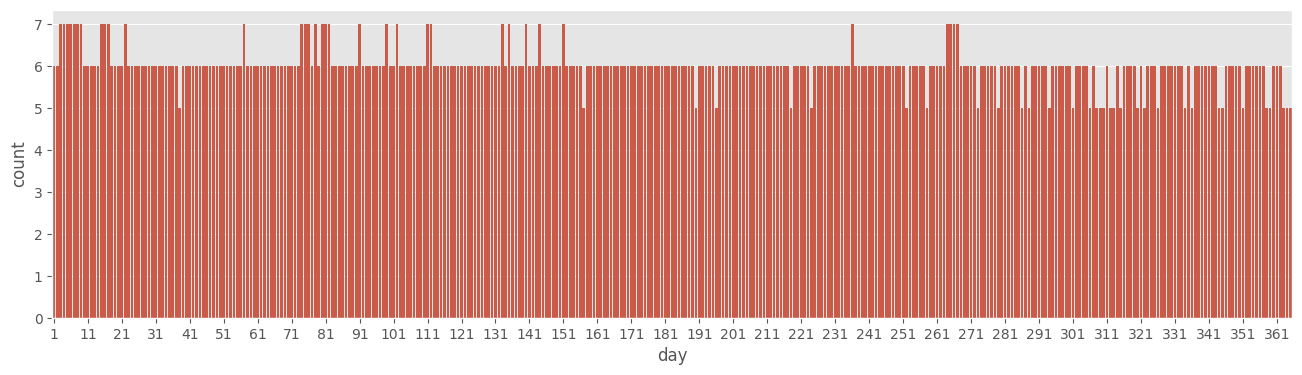

In [8]:
plot_days(train)

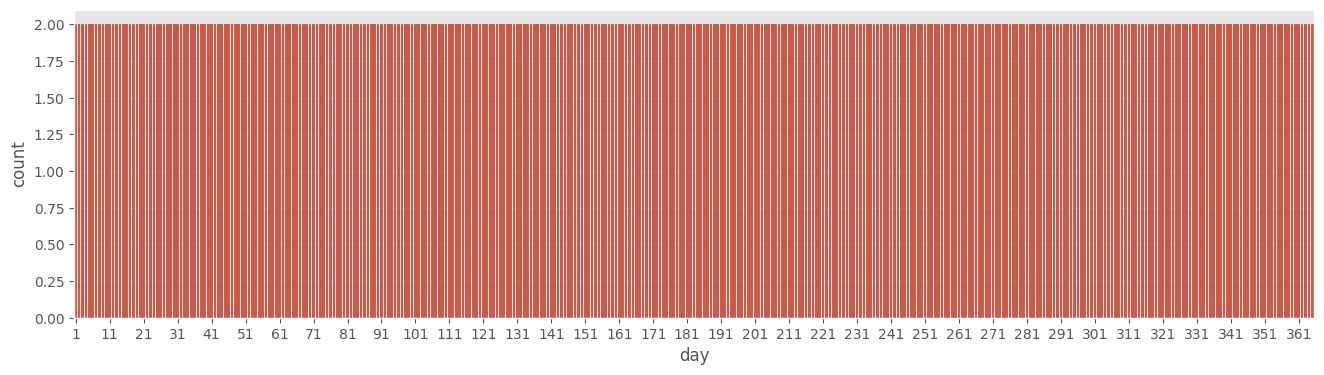

In [9]:
plot_days(test)

В трейне 2190 значений, должно было быть 6 лет показателей (Хотя почему то не учитываются високосные года)  
Но при этом каких то значений 5,6 или 7, надо проверить

In [10]:
def check_wrong_days(df):
    """Проверка на некорректное заполнение поля day"""

    for index, day in df['day'].items():
        if  (index != 2189):
            next_day = df['day'][index+1]
            if (next_day != 1) and (day + 1 != next_day):
                print(f'Индекс - {index}, День - {day}, Следующий день - {next_day}')

In [11]:
check_wrong_days(train)

Индекс - 1036, День - 307, Следующий день - 3
Индекс - 1037, День - 3, Следующий день - 309
Индекс - 1131, День - 37, Следующий день - 265
Индекс - 1132, День - 265, Следующий день - 39
Индекс - 1209, День - 115, Следующий день - 80
Индекс - 1210, День - 80, Следующий день - 117
Индекс - 1250, День - 156, Следующий день - 236
Индекс - 1251, День - 236, Следующий день - 158
Индекс - 1283, День - 189, Следующий день - 4
Индекс - 1284, День - 4, Следующий день - 191
Индекс - 1289, День - 195, Следующий день - 16
Индекс - 1290, День - 16, Следующий день - 197
Индекс - 1311, День - 217, Следующий день - 5
Индекс - 1312, День - 5, Следующий день - 219
Индекс - 1317, День - 223, Следующий день - 6
Индекс - 1318, День - 6, Следующий день - 225
Индекс - 1345, День - 251, Следующий день - 151
Индекс - 1346, День - 151, Следующий день - 253
Индекс - 1351, День - 257, Следующий день - 81
Индекс - 1352, День - 81, Следующий день - 259
Индекс - 1366, День - 272, Следующий день - 264
Индекс - 1367, Д

In [12]:
train.loc[1035:1040,:]

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
1035,1035,306,1016.9,27.5,24.5,23.5,22.4,82.0,88.0,4.5,50.0,24.9,1
1036,1036,307,1014.6,25.2,24.8,23.9,21.2,84.0,70.0,2.1,80.0,33.5,1
1037,1037,3,1015.2,25.0,23.9,23.6,19.9,76.0,61.0,8.8,90.0,14.1,0
1038,1038,309,1017.0,27.7,24.0,22.6,19.6,91.0,78.0,3.3,25.0,16.4,1
1039,1039,310,1018.4,26.4,24.4,23.3,23.3,86.0,66.0,9.7,60.0,8.3,1
1040,1040,311,1020.2,20.6,19.5,18.2,16.8,86.0,88.0,0.1,60.0,43.8,1


Видно что есть косяки с заполнением поля "Day"

In [13]:
def delete_wrong_days(df):
    """Удаление некорректных значений поля day"""

    # Проходим итеративно по датафрейму
    for index in range(df.shape[0]):
        day = df['day'][index]
        
        if (index < 2188) and not pd.isna(day):
            days_iter = 1

            while True:
                # Определяем значение следующего дня
                next_day = df['day'][index+days_iter]
                
                # Если следующий день не совпадает очередностью с предыдущим, то меняем его значение на nan
                if (next_day != 1) and (day + days_iter != next_day):
                    df.loc[index+days_iter, 'day'] = np.nan
                    days_iter += 1
                else:
                    break
    return df

In [14]:
train = delete_wrong_days(train)

In [15]:
train.loc[1033:1039,:]

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
1033,1033,304.0,1015.3,26.0,24.9,23.1,23.2,90.0,83.0,3.5,80.0,24.9,1
1034,1034,305.0,1017.7,27.0,25.6,24.0,23.2,86.0,79.0,1.2,20.0,15.3,1
1035,1035,306.0,1016.9,27.5,24.5,23.5,22.4,82.0,88.0,4.5,50.0,24.9,1
1036,1036,307.0,1014.6,25.2,24.8,23.9,21.2,84.0,70.0,2.1,80.0,33.5,1
1037,1037,NaN,1015.2,25.0,23.9,23.6,19.9,76.0,61.0,8.8,90.0,14.1,0
1038,1038,309.0,1017.0,27.7,24.0,22.6,19.6,91.0,78.0,3.3,25.0,16.4,1
1039,1039,310.0,1018.4,26.4,24.4,23.3,23.3,86.0,66.0,9.7,60.0,8.3,1


In [16]:
def fill_empty_days(df):
    """Заполнение пустых значений поля day"""

    # Разделяем датасет по годам
    for year_number in range(6):
    
        df_year = df.loc[365*year_number:364+365*year_number,'day']

        # Интерполираем пропущенные значения в середине года
        days_interpolated = df_year.interpolate(method='polynomial', order=2)
        df.loc[365*year_number:364+365*year_number,'day'] = days_interpolated
        
        df_year_new = df.loc[365*year_number:364+365*year_number,:]
        not_null_days = df_year_new[df_year_new['day'].isna()==False]
        null_days_index = df_year_new[df_year_new['day'].isna()].index

        # Экстраполируем пропущенные значения на концах года
        f = interpolate.interp1d(not_null_days.index, not_null_days['day'], kind='linear', fill_value='extrapolate')
        days_extrapolated = f(null_days_index)
        df.loc[null_days_index,'day'] = days_extrapolated

    df['day'] = round(df['day']).astype(int)
    
    return df

In [17]:
train = fill_empty_days(train)

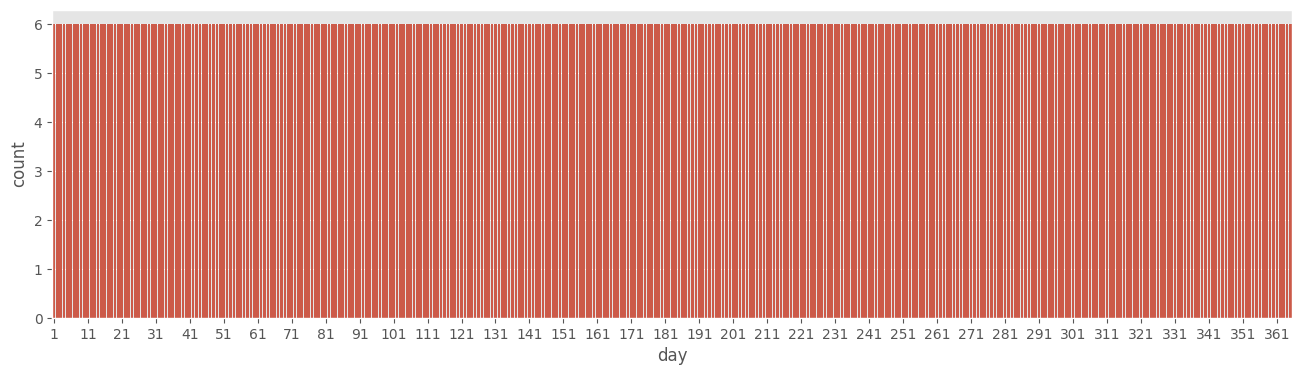

In [18]:
plot_days(train)

In [19]:
check_wrong_days(train)

Теперь все значения поля дат корректные  
Далее проверим, данные являются временным рядом за несколько лет, или набором данных за год из разных мест

In [20]:
def get_season(date):
    """Определение сезона по месяцу"""

    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def create_date_features(df,  date_start):
    """Формирование фичей дат"""

    # Количество лет в датасете
    number_of_years = int(df.shape[0] / 365)

    # Определяем год
    for year_number in range(number_of_years):

        df_year = df.loc[365*year_number:364+365*year_number,:]
        df.loc[df_year.index, 'year'] = date_start + year_number

    df['year'] = df['year'].astype(int).astype(str)

    # Формирование фичей даты, месяца и сезона
    df['date'] = pd.to_datetime(df['year'] + '-' + df['day'].astype(str), format="%Y-%j")
    df['month'] = df['date'].dt.month
    df['season'] = df['date'].apply(get_season)

    return df

In [21]:
train = create_date_features(train,  2020)
test = create_date_features(test,  2026)

In [22]:
def plot_temparature(train, test):
    """График температуры на трейне и тесте"""

    plt.figure(figsize=(16,6))
    plt.plot(train['date'], train['temparature'], label='Train', color='blue')
    plt.plot(test['date'], test['temparature'], label='Test', color='red')

    plt.xlabel('Date')
    plt.ylabel('temparature')
    plt.title('График температуры на трейне и тесте')
    plt.legend()
    plt.grid(True)

    plt.show()

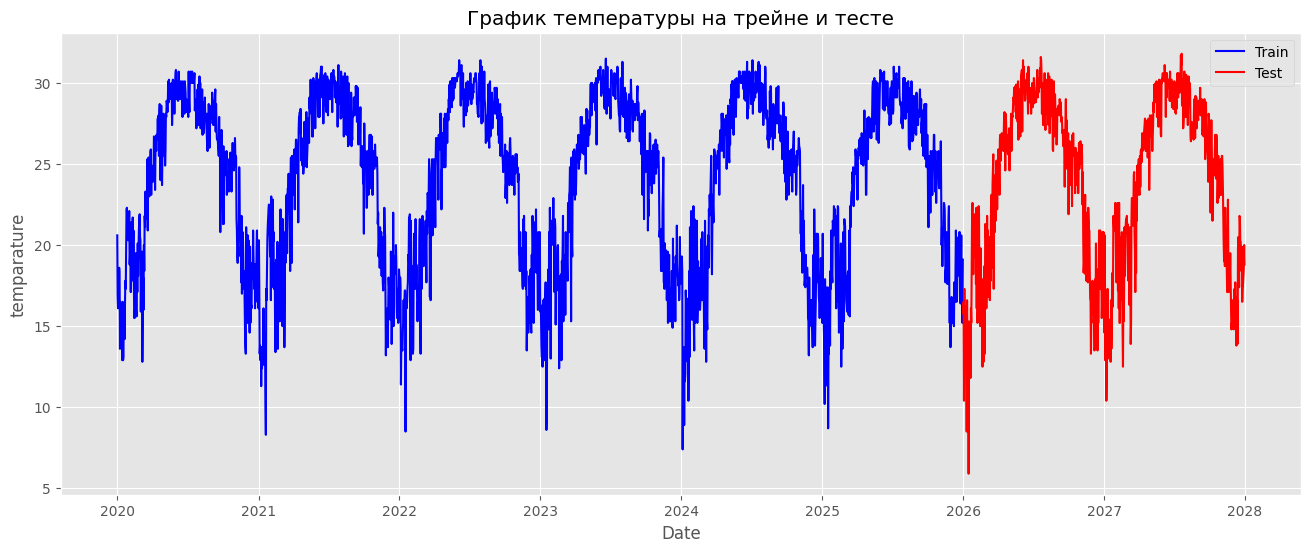

In [23]:
plot_temparature(train, test)

**На основе графиков можно сделать несколько выводов:**
1. Поле day точно обозначает день года, так как наглядно видна сезонная зависимость в данных
2. Данные разных имеют одну и ту же природу. Таким образом можно сделать предположение, что это временной ряд данных из одного физического места. (Но при это почему то отсутствуют високосные года)  
3. Данные не имеют ярко выраженных выбросов

In [24]:
train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,year,date,month,season
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,2020,2020-01-01,1,Winter
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,2020,2020-01-02,1,Winter
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,2020,2020-01-03,1,Winter
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,2020,2020-01-04,1,Winter
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,2020,2020-01-05,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1,2025,2025-12-27,12,Winter
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1,2025,2025-12-28,12,Winter
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1,2025,2025-12-29,12,Winter
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1,2025,2025-12-30,12,Winter


In [25]:
def plot_numeric_cols(df, plot_type):
    """Графики числовых показателей"""

    numeric_cols = df.select_dtypes(include='number').columns[2:-2]
    plt.figure(figsize=(18,24))
    for i in range(len(numeric_cols)):
        col = numeric_cols[i]

        plt.subplot(5,2,i+1)
        plt.title(f'{col}')

        if plot_type=='plot':
            plt.plot(df[col])
        elif plot_type=='boxplot':
            g = sns.boxplot(x=df[col])
            g.set(xlabel=None)

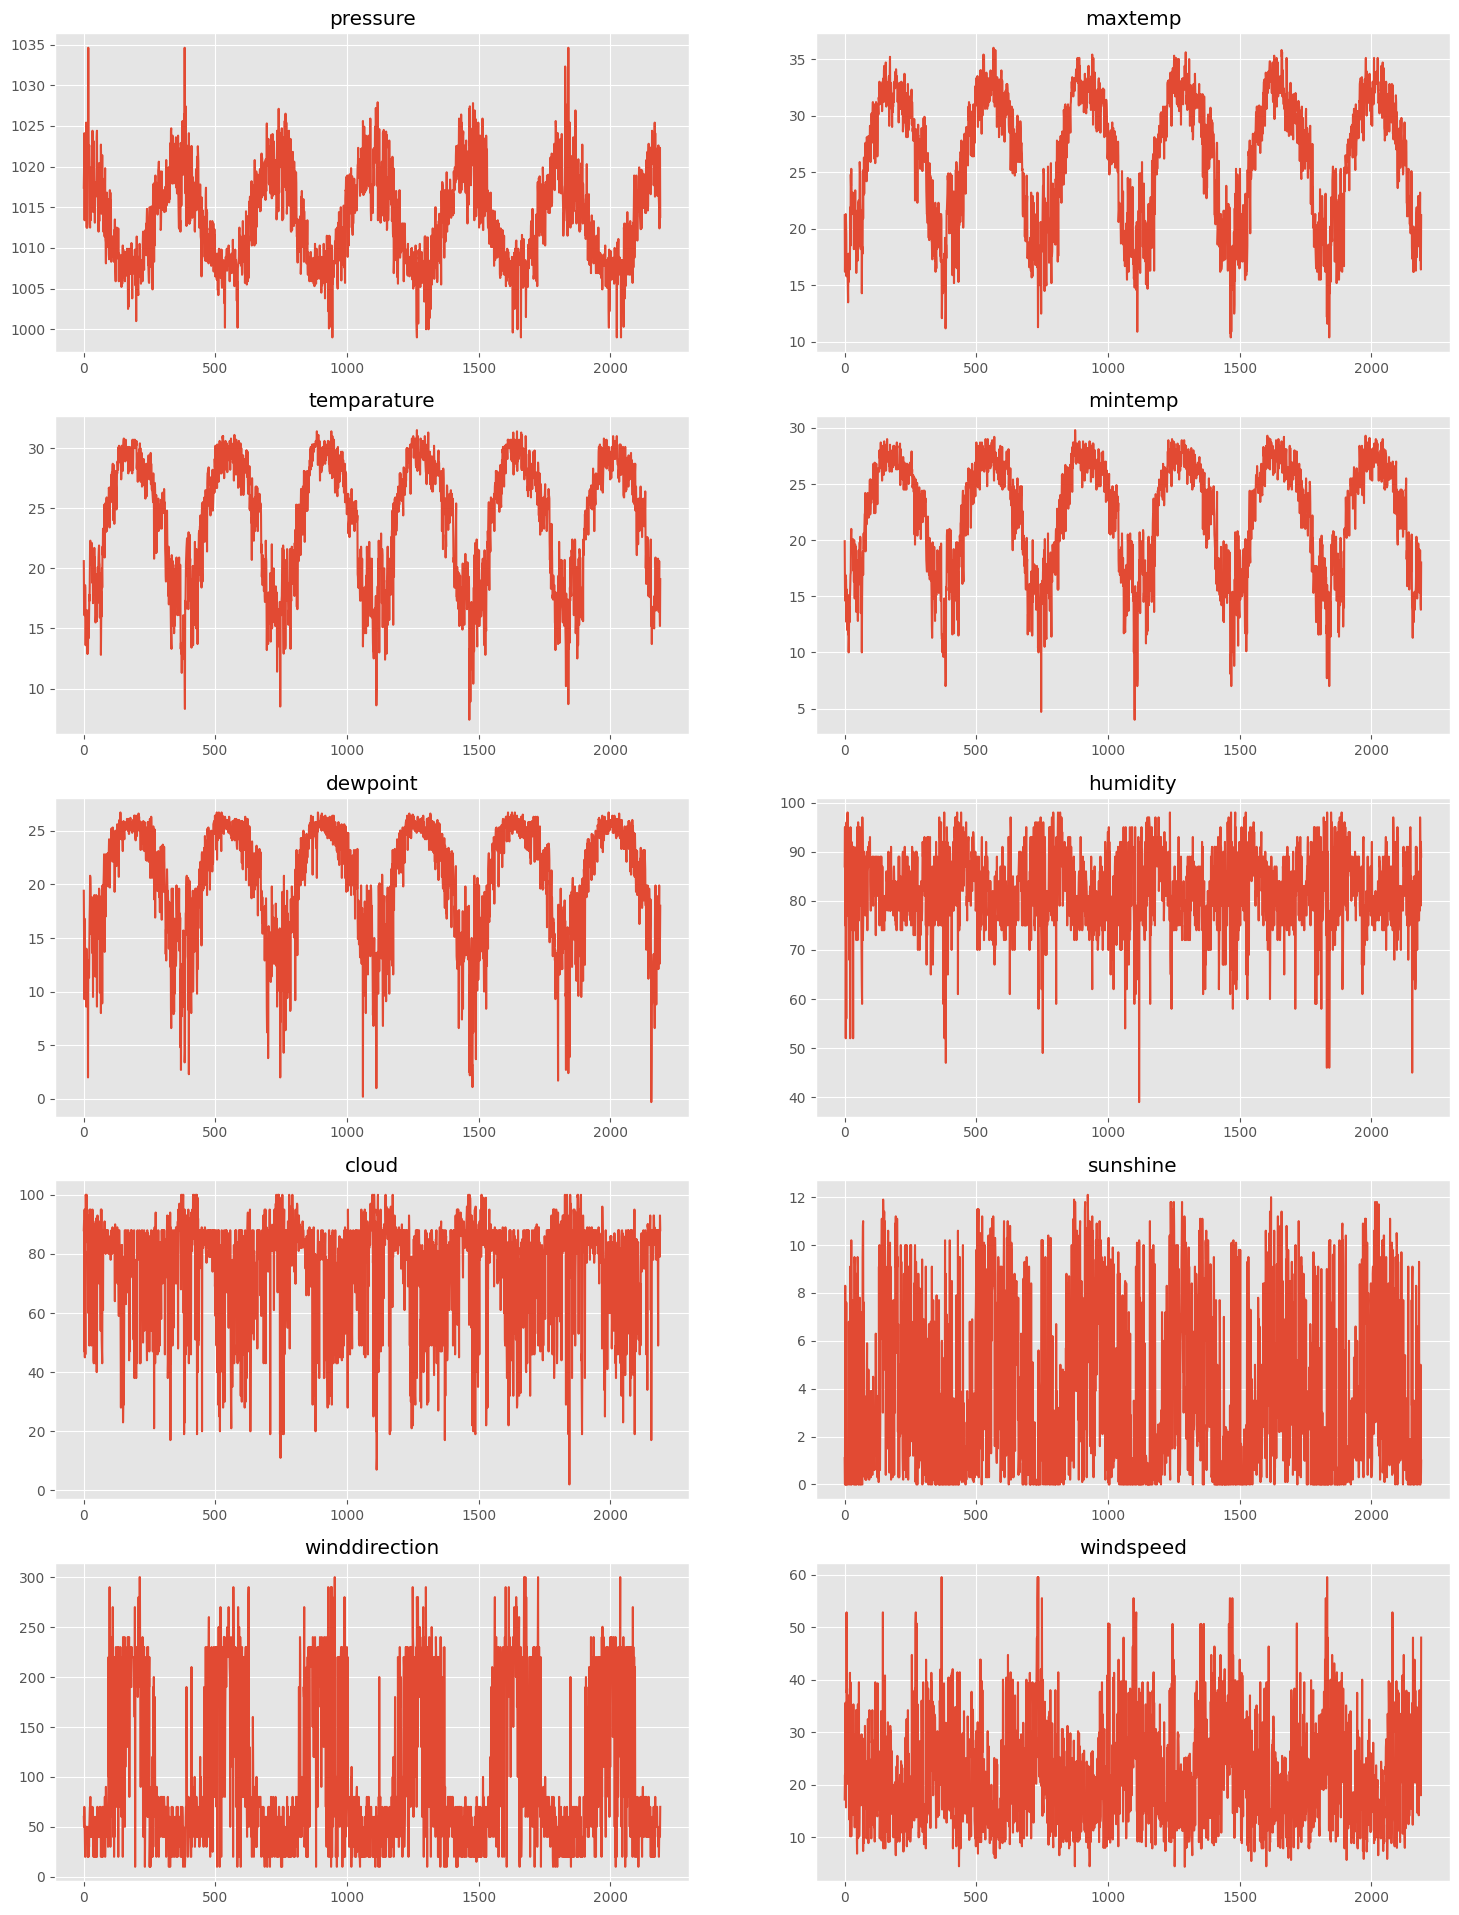

In [26]:
plot_numeric_cols(train, plot_type='plot')

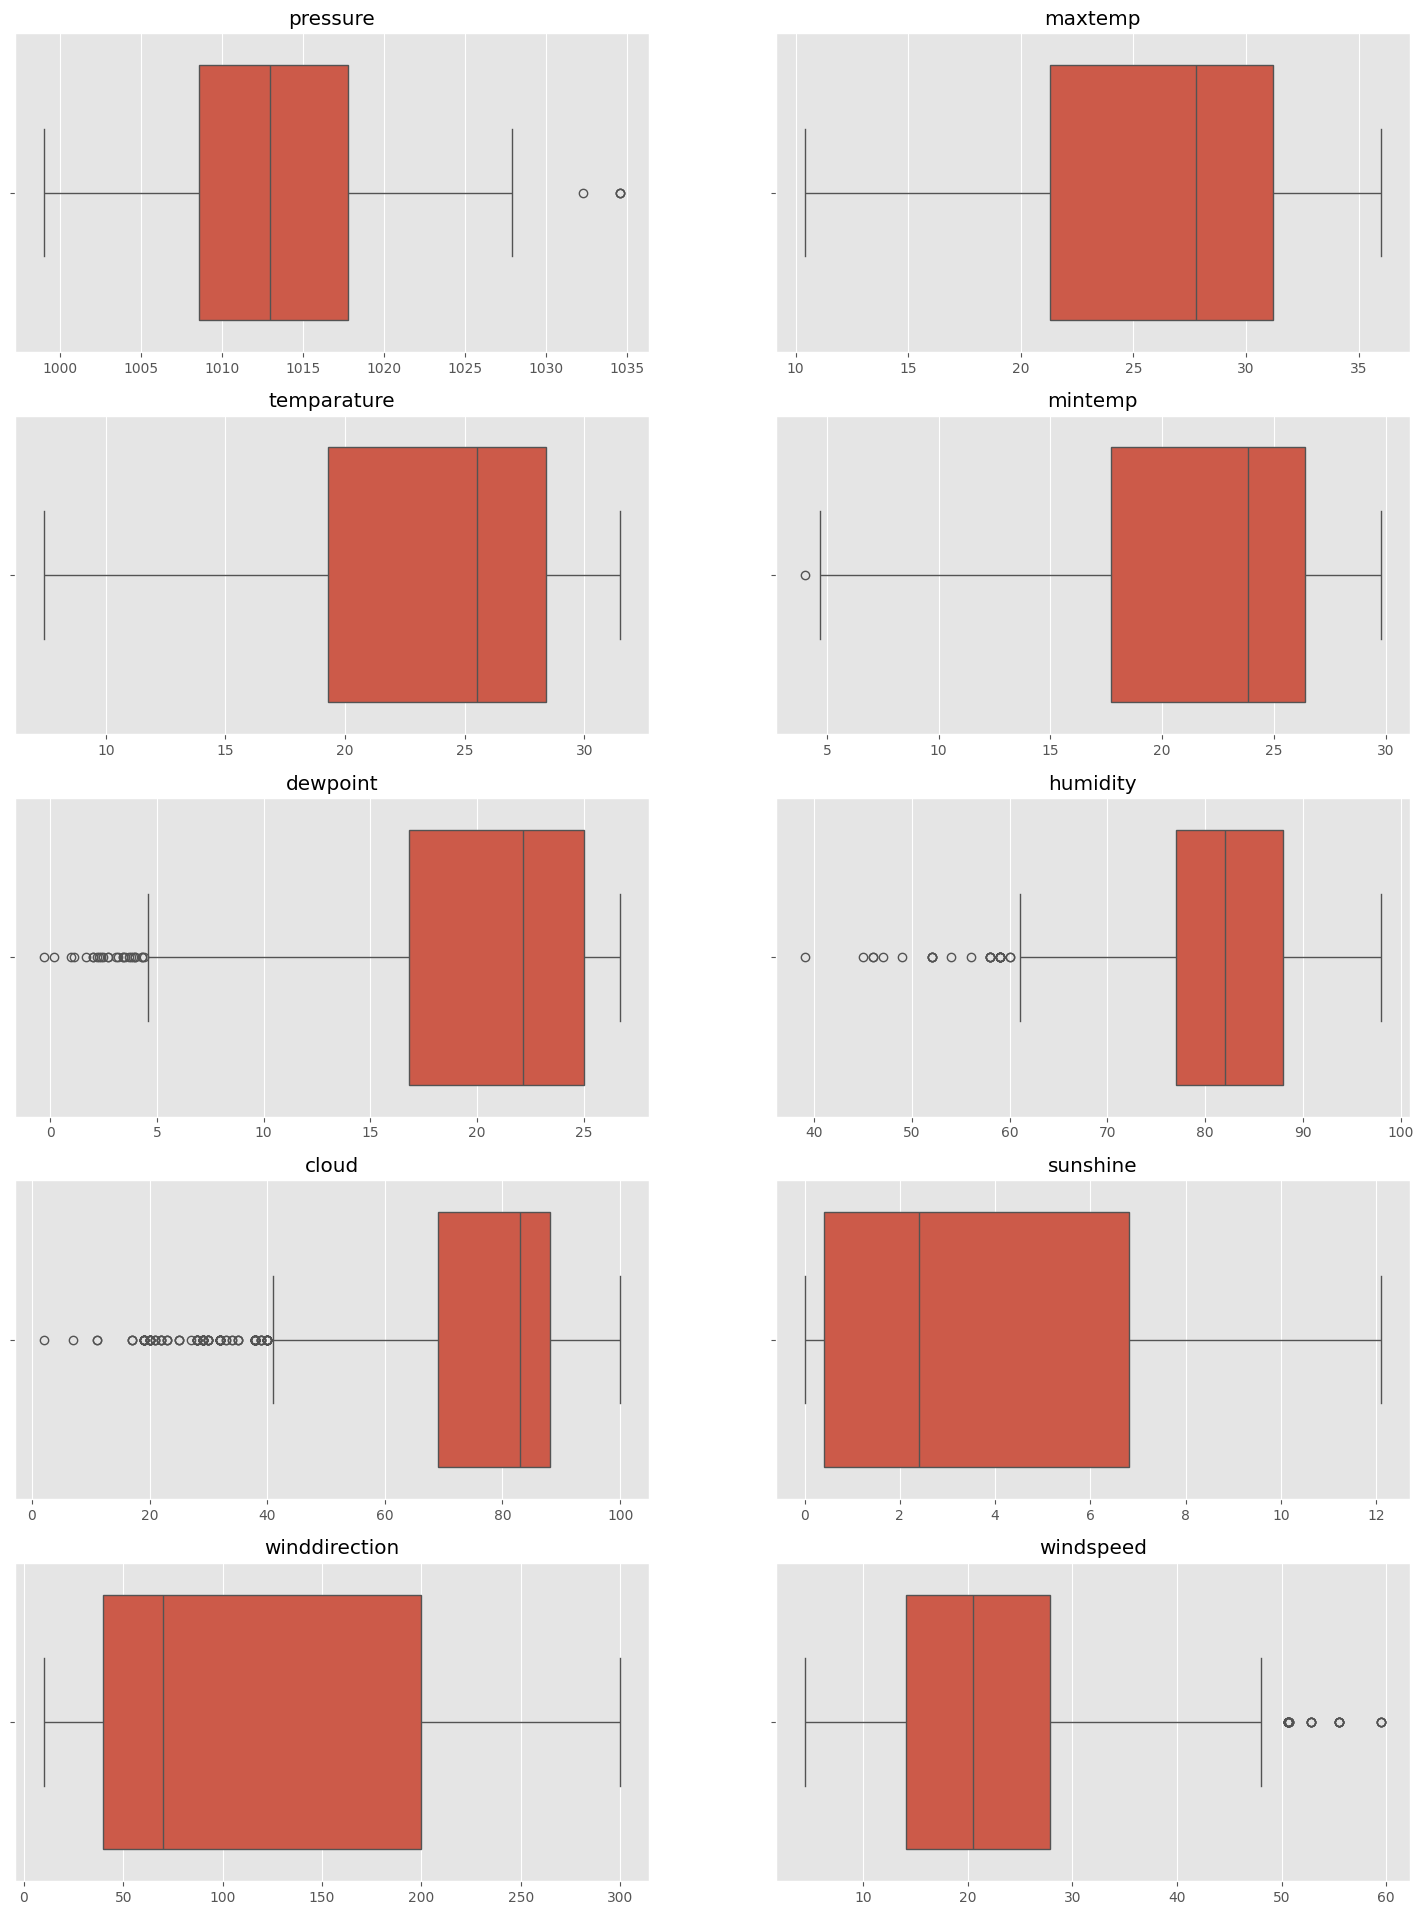

In [27]:
plot_numeric_cols(train, plot_type='boxplot')

In [28]:
def plot_numeric_cols_train_and_test(train, test):
    """Графики числовых показателей на трейне и тесте"""

    numeric_cols = train.select_dtypes(include='number').columns[2:-2]

    for i in range(len(numeric_cols)):
        plt.figure(figsize=(12,4))
        col = numeric_cols[i]

        plt.title(f'{col}')

        plt.plot(train['date'], train[col], label='Train', color='blue')
        plt.plot(test['date'], test[col], label='Test', color='red')

        plt.xlabel('Date')
        plt.legend()
        plt.grid(True)

        plt.show()

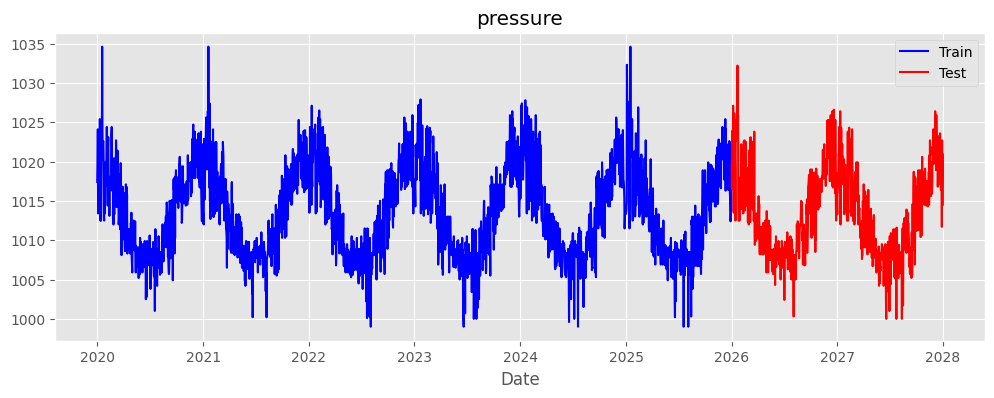

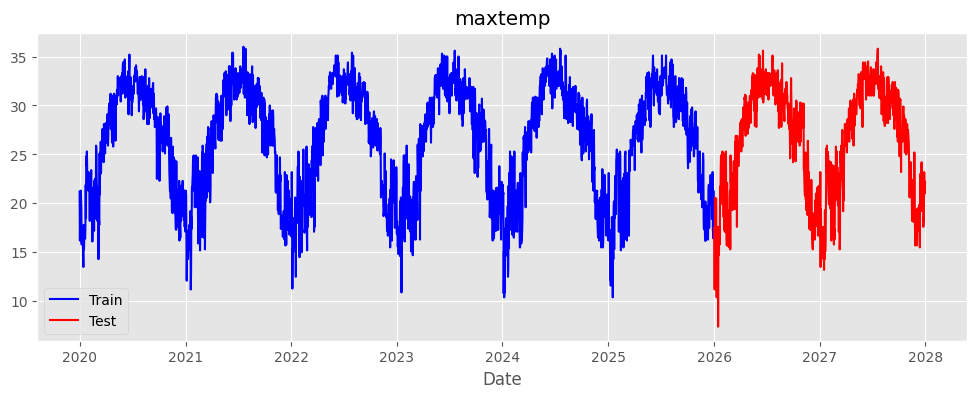

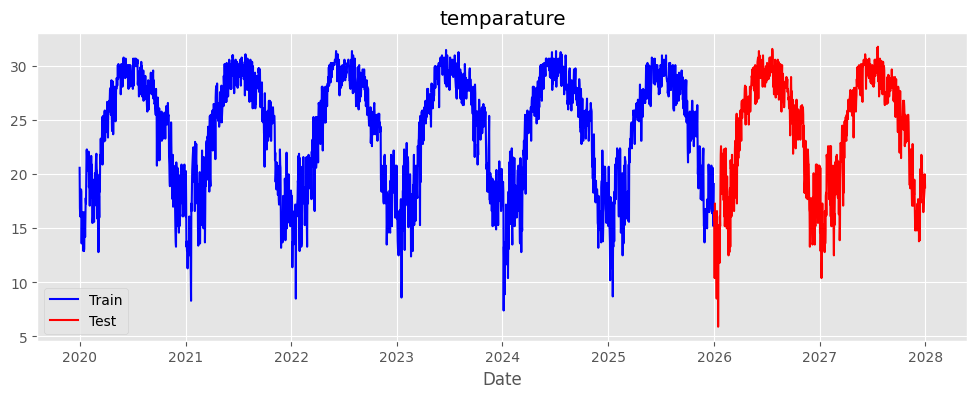

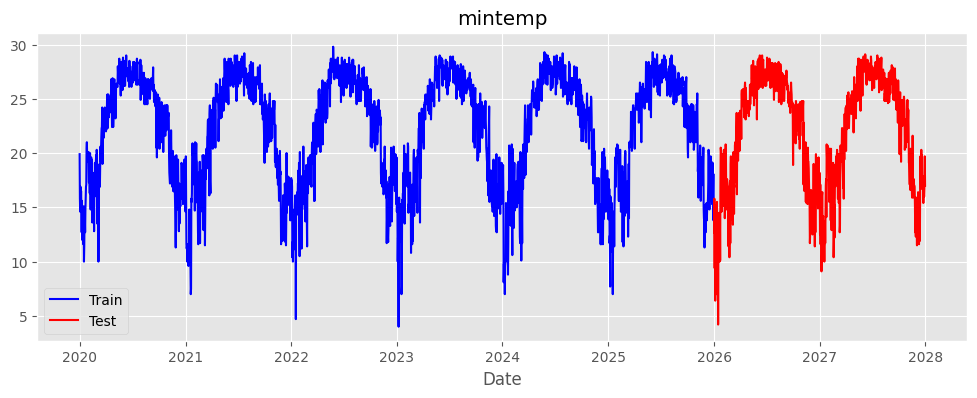

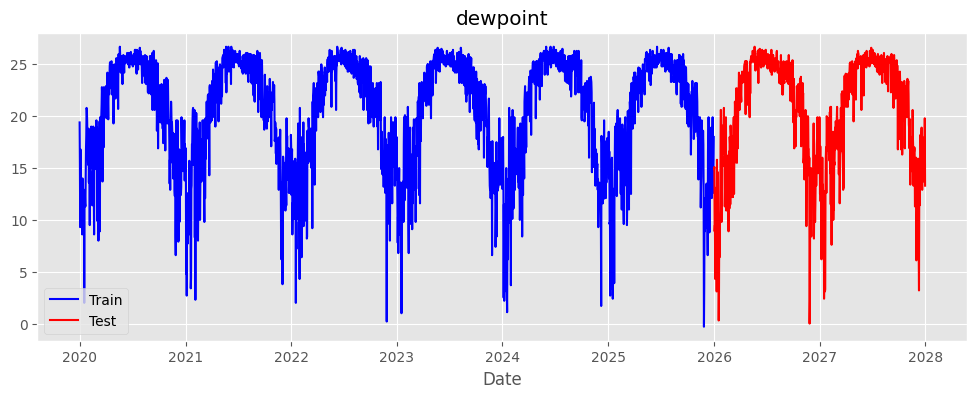

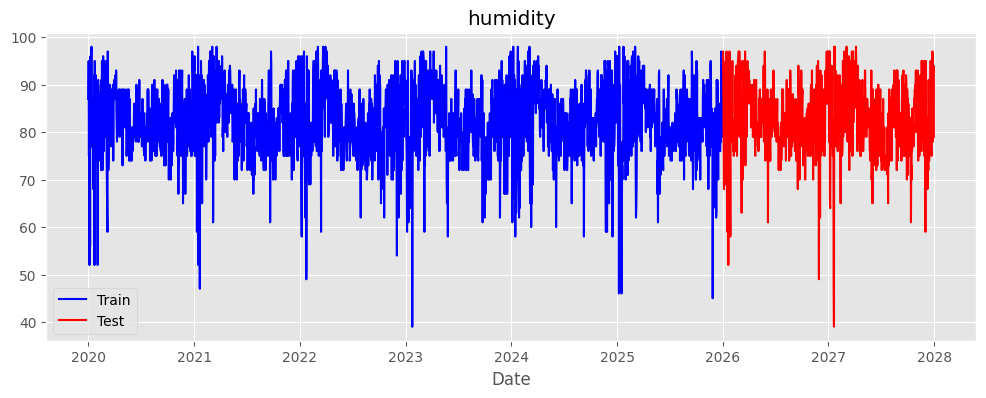

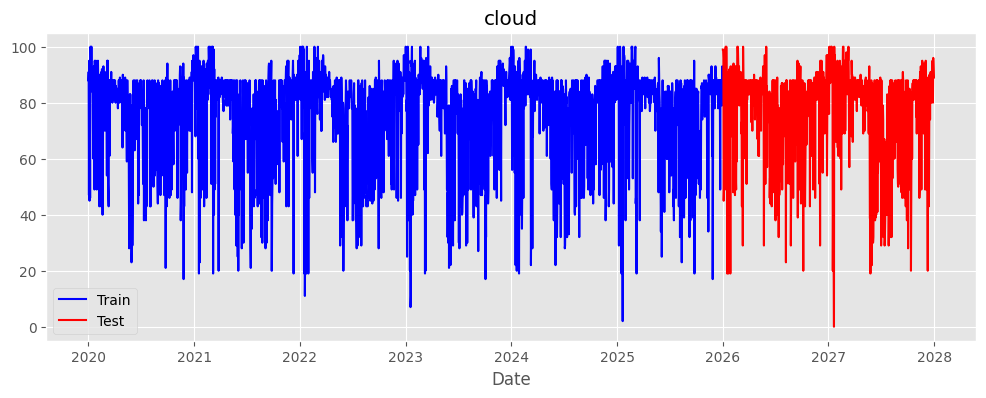

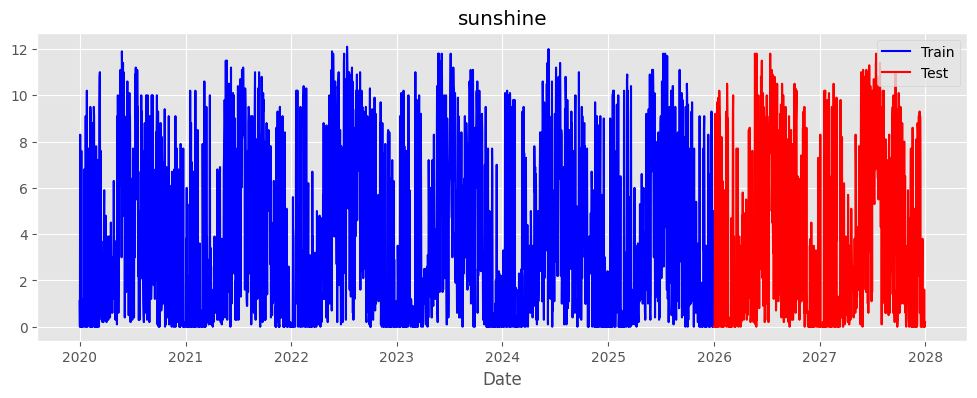

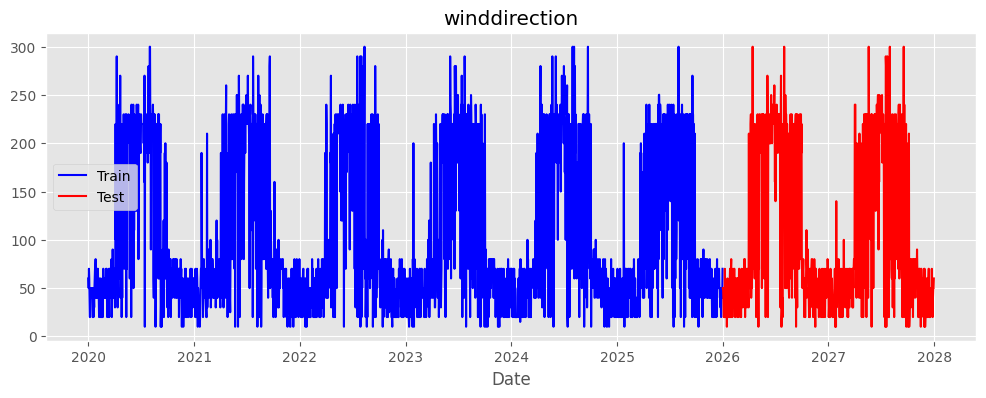

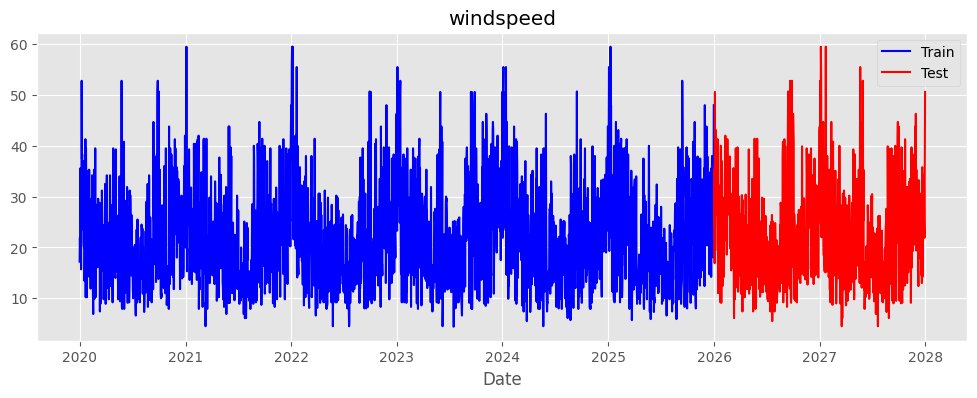

In [29]:
plot_numeric_cols_train_and_test(train, test)

In [30]:
train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,year,date,month,season
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,2020,2020-01-01,1,Winter
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,2020,2020-01-02,1,Winter
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,2020,2020-01-03,1,Winter
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,2020,2020-01-04,1,Winter
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,2020,2020-01-05,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1,2025,2025-12-27,12,Winter
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1,2025,2025-12-28,12,Winter
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1,2025,2025-12-29,12,Winter
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1,2025,2025-12-30,12,Winter


In [31]:
train['rainfall'].value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             2190 non-null   int64         
 1   day            2190 non-null   int32         
 2   pressure       2190 non-null   float64       
 3   maxtemp        2190 non-null   float64       
 4   temparature    2190 non-null   float64       
 5   mintemp        2190 non-null   float64       
 6   dewpoint       2190 non-null   float64       
 7   humidity       2190 non-null   float64       
 8   cloud          2190 non-null   float64       
 9   sunshine       2190 non-null   float64       
 10  winddirection  2190 non-null   float64       
 11  windspeed      2190 non-null   float64       
 12  rainfall       2190 non-null   int64         
 13  year           2190 non-null   object        
 14  date           2190 non-null   datetime64[ns]
 15  month          2190 n

In [33]:
def prepare_dataset_for_train(df, normalize):
    """Подготовка датасета для обучения"""

    # Удаление лишних колонок
    df = df.drop(['id'], axis=1)

    # Кодировка категориальных переменных
    df = pd.get_dummies(df)

    # Переопределение типа данных
    # object_cols = ['winddirection','rainfall']
    object_cols = ['rainfall']
    for col in object_cols:
        df[col] = df[col].astype(str)
    

    # Нормализация числовых показателей
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        if normalize=='mean':
            df[col] = (df[col]-df[col].mean())/df[col].std()
        elif normalize=='min-max':
            df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())

    # Раздление на трейн, валидацию и тест
    train_dataset = df[df['date']<'2024.01.01']
    val_dataset = df[(df['date']>='2024.01.01')&(df['date']<'2025.01.01')]
    test_dataset = df[df['date']>='2025.01.01']
    df = df.drop(['date'], axis=1)
    
    # Выделение целевой переменной
    x_train = train_dataset.drop('rainfall', axis=1)
    y_train = train_dataset['rainfall']

    x_val = val_dataset.drop('rainfall', axis=1)
    y_val = val_dataset['rainfall']

    x_test = test_dataset.drop('rainfall', axis=1)
    y_test = test_dataset['rainfall']

    return x_train, y_train, x_val, y_val, x_test, y_test

In [34]:
x_train, y_train, x_val, y_val, x_test, y_test = prepare_dataset_for_train(train, normalize='mean')

In [35]:
x_train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,year_2020,year_2021,year_2022,year_2023,year_2024,year_2025,season_Autumn,season_Spring,season_Summer,season_Winter
0,-1.726918,0.671549,-0.913601,-0.642052,-0.448713,-0.199411,0.636289,0.681113,-0.729231,-0.560772,...,True,False,False,False,False,False,False,False,False,True
1,-1.717429,1.042878,-1.797879,-1.350537,-1.259130,-0.955783,1.661844,0.847535,-1.032568,-0.685769,...,True,False,False,False,False,False,False,False,False,True
2,-1.707940,1.856264,-1.231941,-1.503723,-1.496326,-2.109249,-0.902044,-1.593317,1.256249,-0.435776,...,True,False,False,False,False,False,False,False,False,True
3,-1.698452,-0.035744,-1.461853,-1.178203,-1.041701,-0.691052,1.661844,1.069430,-1.032568,-0.560772,...,True,False,False,False,False,False,False,False,False,True
4,-1.688963,1.449571,-0.895915,-1.063314,-1.377728,-2.052521,-3.850515,-1.704264,-0.039828,-0.810765,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.688963,0.494726,-1.780193,-1.407982,-1.239364,-1.031420,1.149067,1.124904,-1.032568,-0.435776,...,False,False,False,True,False,False,False,False,False,True
1456,1.698452,0.052667,-1.320368,-1.312241,-1.357962,-0.672143,-0.389266,1.013956,-1.032568,-0.435776,...,False,False,False,True,False,False,False,False,False,True
1457,1.707940,-0.106473,-0.736745,-0.661200,-0.606843,-0.483050,-0.389266,0.292796,-0.425894,-0.435776,...,False,False,False,True,False,False,False,False,False,True
1458,1.717429,0.158761,-1.355740,-1.216500,-1.021935,-0.577597,1.918233,1.069430,-1.032568,-0.685769,...,False,False,False,True,False,False,False,False,False,True


In [36]:
y_train

0       1
1       1
2       1
3       1
4       0
       ..
1455    1
1456    1
1457    1
1458    1
1459    1
Name: rainfall, Length: 1460, dtype: object

## Обучение

In [40]:
import optuna
from sklearn import linear_model, ensemble
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import pickle

In [ ]:
def optuna_optimize(trial, algorithm_name):
    """Функция оптимизации Optuna для бинарной классификации"""
    
    if algorithm_name == 'logistic_regression':
        model = linear_model.LogisticRegression(
            C=trial.suggest_float("C", 0.0001, 10),
            solver='liblinear',
            random_state=33
        )
    elif algorithm_name == 'ridge':
        model = linear_model.RidgeClassifier(
            alpha=trial.suggest_float("alpha", 0.0001, 10),
            random_state=33
        )
    elif algorithm_name == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 1000, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 9, 1),
            max_depth=trial.suggest_int("max_depth", 1, 30, 1),
            criterion=trial.suggest_categorical("criterion", ['gini', 'entropy']),
            random_state=33,
            n_jobs=-1
        )
    elif algorithm_name == 'xgboost':
        model = XGBClassifier(
            min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
            gamma=trial.suggest_float("gamma", 0.5, 5),
            subsample=trial.suggest_float("subsample", 0.6, 1),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            n_estimators=trial.suggest_int("n_estimators", 10, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 1),
            use_label_encoder=False,
            eval_metric='logloss'
        )
    elif algorithm_name == 'catboost':
        model = CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 1500),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.1),
            depth=trial.suggest_int("depth", 3, 12),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-3, 100),
            verbose=False
        )
    elif algorithm_name == 'lgbm':
        model = LGBMClassifier(
            num_leaves=trial.suggest_int("num_leaves", 2, 256),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            n_estimators=trial.suggest_int("n_estimators", 50, 2000),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 100)
        )
    
    # Обучение модели
    model.fit(x_train, y_train)
    
    # Предсказание вероятностей для вычисления ROC AUC
    y_pred_proba = model.predict_proba(x_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    return roc_auc

In [ ]:
def train_optuna(algorithms, is_save):
    """Подбор гиперпараметров через Optuna"""

    for algorithm_name in algorithms:
        print(f"Оптимизация для {algorithm_name}...")
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: optuna_optimize(trial, algorithm_name), n_trials=20, n_jobs=-1)

        # print(f"Лучшие параметры для {algorithm_name}: {study.best_params}")

        # Сохранение параметров
        if is_save:
            with open(f'params/{algorithm_name}_params.pkl', 'wb') as f:
                pickle.dump(study.best_params, f)

In [53]:
algorithms = ['logistic_regression','ridge','random_forest','xgboost','catboost','lgbm']
train_optuna(algorithms, is_save = True)

[I 2025-03-02 18:38:26,575] A new study created in memory with name: no-name-c3abf55e-b053-41f8-a9ab-747287a3af21
[W 2025-03-02 18:38:26,577] Trial 0 failed with parameters: {} because of the following error: NameError("name 'algorithm_name' is not defined").
Traceback (most recent call last):
  File "c:\Users\Илья\Desktop\Workflow\Саморазвитие\Кагл\rainfall predict\venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Илья\AppData\Local\Temp\ipykernel_2692\1177853330.py", line 4, in optuna_optimize
    if algorithm_name == 'logistic_regression':
NameError: name 'algorithm_name' is not defined
[W 2025-03-02 18:38:26,582] Trial 1 failed with parameters: {} because of the following error: NameError("name 'algorithm_name' is not defined").
Traceback (most recent call last):
  File "c:\Users\Илья\Desktop\Workflow\Саморазвитие\Кагл\rainfall predict\venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_tri

NameError: name 'algorithm_name' is not defined